# ITS-ENEM



### Import libraries

In [1]:
# model/models.py

from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Union
import yaml
import networkx as nx
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import json

## Models

### Domain Model

In [2]:
class DomainModel:

    def __init__(self, domain_file: str):
        try:
          with open(domain_file, 'r') as f:
            self.domain = yaml.safe_load(f)
        except:
          url = domain_file
          try:
              response = requests.get(url)
              response.raise_for_status()
              yaml_data = yaml.safe_load(response.text)
              self.domain = yaml_data
          except requests.exceptions.RequestException as e:
              print(f"Error fetching YAML from {url}: {e}")
              self.domain = None
          except yaml.YAMLError as e:
              print(f"Error parsing YAML from {url}: {e}")
              self.domain = None

    def print_domain(self, domain=None, indent=0):
        """Pretty print the domain hierarchy."""
        if domain is None:
            domain = self.domain
        for key, value in domain.items():
            print("  " * indent + key)
            if isinstance(value, dict):
                self.print_domain(value, indent + 1)
            elif isinstance(value, list):
                for item in value:
                    print("  " * (indent + 1) + "- " + item)

    def plot(self, area=None, topico=None, root='Ciências da Natureza', simulate_colors=False):
        """Plot the domain hierarchy as a directed graph in a tree-like structure."""
        G = nx.DiGraph()

        # Build the graph
        if area:
            if topico:
                self._build_graph(G, {area: {topico: self.domain[root][area][topico]}})
            else:
                self._build_graph(G, {area: self.domain[root][area]})
        else:
            self._build_graph(G, self.domain[root])

        # Ensure the graph is acyclic
        if not nx.is_directed_acyclic_graph(G):
            raise ValueError("The graph contains cycles and cannot be plotted as a tree.")

        # Compute levels (depth) and topological order
        topo_order = list(nx.topological_sort(G))
        levels = {}  # Depth of each node
        for node in topo_order:
            levels[node] = max([levels.get(pred, 0) + 1 for pred in G.predecessors(node)], default=0)

        # Compute x-coordinates using a tree-like spacing strategy
        pos = {}
        x_positions = {}  # Track x-position for each node
        level_widths = {}  # Track the number of nodes per level for spacing

        # First pass: Assign initial x-positions based on order within each level
        for node in topo_order:
            level = levels[node]
            if level not in level_widths:
                level_widths[level] = 0
            x_positions[node] = level_widths[level]
            level_widths[level] += 1

        # Second pass: Adjust x-positions to center children under parents
        for node in reversed(topo_order):  # Bottom-up adjustment
            children = list(G.successors(node))
            if children:
                avg_child_x = sum(x_positions[child] for child in children) / len(children)
                x_positions[node] = avg_child_x
            pos[node] = (x_positions[node], -levels[node])  # Shortened edges

        # Normalize x-positions to avoid overlap
        max_width = max(level_widths.values())
        if max_width > 1:
            for node in pos:
                pos[node] = (pos[node][0] * 2.0 / (max_width - 1), pos[node][1])

        # Determine node colors
        if simulate_colors:
            num_nodes = G.number_of_nodes()
            colors = np.random.choice(
                ['#DC143C', '#FFD700', '#2E8B57'],
                size=num_nodes,
                p=[0.3, 0.4, 0.3]  # 30% red, 40% yellow, 30% green
            )
            node_color = colors
        else:
            node_color = "skyblue"  # Default color

        # Create a larger figure to accommodate the graph
        plt.figure(figsize=(12, 8))  # Increase figure size (width, height)

        # Draw nodes and edges
        nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=node_color)
        nx.draw_networkx_edges(G, pos)

        # Draw rotated labels manually using Matplotlib
        for node, (x, y) in pos.items():
            plt.text(x, y, str(node), fontsize=10, fontweight="bold",
                    ha='center', va='center', rotation=45)

        plt.title("Domain Model" if area and topico else "")

        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Add extra padding to ensure labels aren't cut off
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

        # Remove the border box (spines) and ticks
        ax = plt.gca()  # Get the current axes
        ax.set_frame_on(False)  # Turn off the frame (border box)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks

        plt.show()

    def _build_graph(self, G, domain, parent=None):
        """Recursively build the graph from the domain dictionary."""
        for key, value in domain.items():
            G.add_node(key)
            if parent:
                G.add_edge(parent, key)
            if isinstance(value, dict):
                self._build_graph(G, value, key)
            elif isinstance(value, list):
                for item in value:
                    G.add_node(item)
                    G.add_edge(key, item)


In [3]:
class ENEM(DomainModel):
    def __init__(self, domain_file: str, enem_file: str):
        """
        Initialize the ENEM class by loading the domain model and ENEM questions.

        Args:
            domain_file: Path or URL to the YAML domain file
            enem_file: Path or URL to the JSONL file containing ENEM questions
        """
        # Load the domain model using the parent class
        super().__init__(domain_file)

        # Load and store ENEM questions
        self.questions = self._load_enem_questions(enem_file)

        # Optionally integrate questions into the domain (if that's your intent)
        if self.domain is not None and self.questions:
            self._integrate_questions_into_domain()

    def _load_enem_questions(self, enem_file: str) -> List[Dict]:
        """Load ENEM questions from a local file or URL."""
        questions = []
        if enem_file.startswith(('http://', 'https://')):
            response = requests.get(enem_file)
            response.raise_for_status()
            lines = response.text.splitlines()
            for line in response.text.splitlines():
                if line.strip():
                    try:
                      enem_question = json.loads(line)
                      question = self._convert_enem_question(enem_question)
                      questions.append(question)
                    except:
                      print('erro - ', line)

        else:
            with open(enem_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip():
                        enem_question = json.loads(line)
                        question = self._convert_enem_question(enem_question)
                        questions.append(question)
        return questions

    def _convert_enem_question(self, enem_question: dict) -> dict:
        """
        Convert an ENEM question to the system's expected format.

        Args:
            enem_question: Dictionary containing an ENEM question

        Returns:
            Dictionary in the system's expected format
        """
        question = {
            "id": enem_question["id"],
            "correct": enem_question["label"],
            "difficulty": enem_question["difficulty"],
            "topics": {}
        }
        area = enem_question["area"]
        topics = enem_question.get("topico", [])
        if isinstance(topics, str):
            topics = [topics]
        question["topics"][area] = []
        for topic in topics:
            if isinstance(topic, list):
                question["topics"][area].append(topic)
            else:
                question["topics"][area].append([topic])
        return question

    def _integrate_questions_into_domain(self):
        """Integrate ENEM questions into the domain model structure."""
        # Assuming the domain has a structure like {root: {area: {topic: ...}}}
        if "questions" not in self.domain:
            self.domain["questions"] = {}
        for question in self.questions:
            qid = question["id"]
            self.domain["questions"][qid] = {
                "correct": question["correct"],
                "difficulty": question["difficulty"],
                "topics": question["topics"]
            }

### LearnerModel

In [4]:
class LearnerModel(BaseModel):
    id: str = Field(..., description="Unique identifier for the learner")
    answers: Dict[str, str] = Field(..., description="Answers to questions (question_id: A/B/C/D/E)")
    performance: Optional[Dict[str, Dict]] = Field(None, description="Performance metrics")

    def print_performance(self):
        """Pretty print the learner's performance metrics."""
        if not self.performance:
            print("No performance data available.")
            return
        print(f"Performance for {self.id}:")
        for category, metrics in self.performance.items():
            print(f"  {category.capitalize()}:")
            for key, value in metrics.items():
                print(f"    {key}: {value}")

    class Config:
        schema_extra = {
            "example": {
                "id": "learner_001",
                "answers": {"1": "A", "2": "B", "3": "C"},
                "performance": {
                    "topics": {
                        "Membrana Plasmática": {
                            "total_questions": 5,
                            "percent_correct_easy_questions": 80.0,
                            "percent_correct_medium_questions": 50.0,
                            "percent_correct_hard_questions": 33.3,
                            "points": 10
                        }
                    },
                    "areas": {
                        "Biologia": {
                            "total_questions": 60,
                            "percent_correct_easy_questions": 75.0,
                            "percent_correct_medium_questions": 60.0,
                            "percent_correct_hard_questions": 40.0,
                            "points": 80
                        }
                    }
                }
            }
        }

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


### Pedagogy Model

In [5]:
class PedagogyModel:

    def __init__(self, pedagogy_file: str, threshold_topics: float = 50.0, threshold_areas: float = 50.0):
        try:
          with open(pedagogy_file, 'r') as f:
            yaml_data = yaml.safe_load(f)
        except:
          url = pedagogy_file
          response = requests.get(url, headers={
              'Cache-Control': 'no-cache', # Or 'no-store'
              'Pragma': 'no-cache'         # Optional, for wider compatibility
          })
          response.raise_for_status()
          yaml_data = yaml.safe_load(response.text)

        self.feedback_types = yaml_data.get('feedback_types', [])
        self.rules = yaml_data.get('feedback_rules', [])
        self.threshold_topics = threshold_topics
        self.threshold_areas = threshold_areas

    def apply_rules(self, learner: LearnerModel) -> Dict:
        """Apply pedagogical rules to evaluate learner performance."""
        feedback = {"topics": {}, "areas": {}}

        # Initialize feedback for each topic and area
        if learner.performance:
            for topic in learner.performance.get("topics", {}):
                feedback["topics"][topic] = {"needs_review": False}
            for area in learner.performance.get("areas", {}):
                feedback["areas"][area] = {"needs_focus": False}

        # Check topics below threshold
        for topic, data in learner.performance.get("topics", {}).items():
            if data.get("percent_correct", 0) < self.threshold_topics:
                feedback["topics"][topic]["needs_review"] = True

        # Check areas below threshold
        for area, data in learner.performance.get("areas", {}).items():
            if data.get("percent_correct", 0) < self.threshold_areas:
                feedback["areas"][area]["needs_focus"] = True

        # Apply custom rules from pedagogy.yml
        if self.rules:
            for rule in self.rules:
                rule_name = rule.get("name", "Unnamed Rule")
                condition = rule.get("condition", {})
                if self._evaluate_condition(condition, learner):
                    action = rule.get("action", "")
                    action_parts = action.split("(")
                    action_type = action_parts[0]
                    if action_type == "provide_hint":
                        topic = action_parts[1].strip(")").strip("'").strip('"')
                        if topic in feedback["topics"]:
                            feedback["topics"][topic]["needs_hint"] = True
                    elif action_type == "suggest_visualization":
                        topic = action_parts[1].strip(")").strip("'").strip('"')
                        if topic in feedback["topics"]:
                            feedback["topics"][topic]["needs_visualization"] = True

        return feedback

    def _evaluate_condition(self, condition: Dict, learner: LearnerModel) -> bool:
        """Evaluate a rule condition recursively."""
        if not condition:
            return False
        condition_type = condition.get("type", "")
        if condition_type == "and":
            return all(self._evaluate_condition(cond, learner) for cond in condition.get("conditions", []))
        elif condition_type == "or":
            return any(self._evaluate_condition(cond, learner) for cond in condition.get("conditions", []))
        elif condition_type in ["less_than", "greater_than", "equal", "greater_than_or_equal", "less_than_or_equal"]:
            left_value = self._resolve_reference(condition.get("left", ""), learner)
            right_value = self._resolve_reference(condition.get("right", ""), learner)
            if left_value is None or right_value is None:
                return False
            if condition_type == "less_than":
                return left_value < right_value
            elif condition_type == "greater_than":
                return left_value > right_value
            elif condition_type == "equal":
                return left_value == right_value
            elif condition_type == "greater_than_or_equal":
                return left_value >= right_value
            elif condition_type == "less_than_or_equal":
                return left_value <= right_value
        return False

    def _resolve_reference(self, reference, learner: LearnerModel):
        """Resolve a reference to a value in the learner model."""
        if isinstance(reference, (int, float, bool)):
            return reference
        if not isinstance(reference, str):
            return None
        if reference.startswith("performance."):
            path = reference[11:].split(".")
            value = learner.performance
            for key in path:
                if isinstance(value, dict) and key in value:
                    value = value[key]
                else:
                    return None
            return value
        return reference

    def print_rules(self):
        """Pretty print the pedagogical rules with readable conditions and actions."""
        print("Pedagogical Rules:")
        for rule in self.rules:
            print(f"  Rule: {rule.get('name', 'Unnamed')}")
            condition_str = self._format_condition(rule.get('condition', {}))
            print(f"    Condition: {condition_str}")
            print(f"    Action: {rule.get('action', 'No action specified')}")
            print()

    def _format_condition(self, condition):
        """Format a condition dictionary into a readable string."""
        if not condition:
            return "No condition"
        condition_type = condition.get("type", "")
        if condition_type in ["and", "or"]:
            sub_conditions = [self._format_condition(cond) for cond in condition.get("conditions", [])]
            return f" {condition_type.upper()} ".join(sub_conditions)
        elif condition_type in ["less_than", "greater_than", "equal", "greater_than_or_equal", "less_than_or_equal"]:
            left = condition.get("left", "unknown")
            right = condition.get("right", "unknown")
            operator = {
                "less_than": "<",
                "greater_than": ">",
                "equal": "==",
                "greater_than_or_equal": ">=",
                "less_than_or_equal": "<="
            }[condition_type]
            return f"{left} {operator} {right}"
        return str(condition)


## Controller

In [6]:
# controller.py

# from typing import List, Dict
# from model.models import DomainModel, LearnerModel, PedagogyModel

class Controller:
    def __init__(self, domain_model: DomainModel, pedagogy_model: PedagogyModel, questions: List[Dict]):
        self.domain_model = domain_model
        self.pedagogy_model = pedagogy_model
        self.questions = questions
        self.difficulty_points = {"easy": 1, "medium": 2, "high": 3}
        self.learners = []

    def process_learner(self, learner: LearnerModel) -> LearnerModel:
        performance = {"topics": {}, "areas": {}}

        for q in self.questions:
            correct = learner.answers[q["id"]] == q["correct"]
            difficulty = q["difficulty"]

            # Process areas
            for area in q["topics"].keys():
                if area not in performance["areas"]:
                    performance["areas"][area] = {
                        "total_questions": 0,
                        "correct_easy": 0, "total_easy": 0,
                        "correct_medium": 0, "total_medium": 0,
                        "correct_high": 0, "total_high": 0,
                        "points": 0
                    }
                performance["areas"][area]["total_questions"] += 1
                if correct:
                    performance["areas"][area][f"correct_{difficulty}"] += 1
                    performance["areas"][area]["points"] += self.difficulty_points[difficulty]
                performance["areas"][area][f"total_{difficulty}"] += 1

            # Process topics
            for area, topic_paths in q["topics"].items():
                for path in topic_paths:
                    leaf_topic = path[-1]
                    if leaf_topic not in performance["topics"]:
                        performance["topics"][leaf_topic] = {
                            "total_questions": 0,
                            "correct_easy": 0, "total_easy": 0,
                            "correct_medium": 0, "total_medium": 0,
                            "correct_high": 0, "total_high": 0,
                            "points": 0
                        }
                    performance["topics"][leaf_topic]["total_questions"] += 1
                    if correct:
                        performance["topics"][leaf_topic][f"correct_{difficulty}"] += 1
                        performance["topics"][leaf_topic]["points"] += self.difficulty_points[difficulty]
                    performance["topics"][leaf_topic][f"total_{difficulty}"] += 1

        # Calculate percentages for topics
        for topic, data in performance["topics"].items():
            for diff in ["easy", "medium", "high"]:
                total = data.get(f"total_{diff}", 0)
                correct = data.get(f"correct_{diff}", 0)
                data[f"percent_correct_{diff}_questions"] = (correct / total * 100) if total > 0 else 0.0
            # Clean up temporary counters
            del data["correct_easy"], data["total_easy"], data["correct_medium"], data["total_medium"], data["correct_high"], data["total_high"]

        # Calculate percentages for areas
        for area, data in performance["areas"].items():
            for diff in ["easy", "medium", "high"]:
                total = data.get(f"total_{diff}", 0)
                correct = data.get(f"correct_{diff}", 0)
                data[f"percent_correct_{diff}_questions"] = (correct / total * 100) if total > 0 else 0.0
            del data["correct_easy"], data["total_easy"], data["correct_medium"], data["total_medium"], data["correct_high"], data["total_high"]

        learner.performance = performance
        self.learners.append(learner)
        return learner

    def apply_pedagogy(self, learner: LearnerModel) -> Dict:
        """Apply pedagogical rules to evaluate learner performance."""
        return self.pedagogy_model.apply_rules(learner)

    def generate_report(self, feedback_flags: Dict, learner_id: str) -> str:
        """Generate a human-readable report based on feedback flags using messages from pedagogy.yml."""
        # Create a lookup dictionary for feedback messages
        feedback_messages = {ftype["name"]: ftype["message"] for ftype in self.pedagogy_model.feedback_types}

        # Initialize the report
        report = f"Feedback Report for {learner_id}\n\n"

        # Topics section
        report += "**Feedback on Topics:**\n"
        topics_with_feedback = [
            topic for topic in feedback_flags["topics"]
            if feedback_flags["topics"][topic].get("needs_review", False)
        ]
        if topics_with_feedback:
            for topic in sorted(topics_with_feedback):
                report += f"- {feedback_messages['review'].format(item=topic)}\n"
        else:
            report += "- No topics require review at this time.\n"
        report += "\n"

        # Areas section
        report += "**Feedback on Areas:**\n"
        areas_with_feedback = [
            area for area in feedback_flags["areas"]
            if feedback_flags["areas"][area].get("needs_focus", False)
        ]
        if areas_with_feedback:
            for area in sorted(areas_with_feedback):
                report += f"- {feedback_messages['relatedness'].format(item=area)}\n"
        else:
            report += "- No areas need additional focus at this time.\n"

        return report

## Initialize and run example

### Load Domain

In [7]:
domain_file = "https://raw.githubusercontent.com/adaj/its-enem/refs/heads/main/model/domain.yml"

domain_model = DomainModel(domain_file)
domain_model.domain['Ciências da Natureza']['Biologia']['Citologia']

{'Estrutura Celular': ['Membrana Plasmática',
  'Citoplasma',
  'Organelas (Mitocôndrias, Cloroplastos, etc.)'],
 'Função Celular': ['Metabolismo Energético',
  'Síntese Proteica',
  'Transporte de Substâncias'],
 'Divisão Celular': ['Mitose', 'Meiose', 'Ciclo Celular']}

In [8]:
root = 'Ciências da Natureza'
area = 'Biologia'
topico = 'Citologia'

print(f"Domain Model Hierarchy: \n{area}->{topico}\n")
domain_model.print_domain(domain=domain_model.__dict__['domain'][root][area][topico])

Domain Model Hierarchy: 
Biologia->Citologia

Estrutura Celular
  - Membrana Plasmática
  - Citoplasma
  - Organelas (Mitocôndrias, Cloroplastos, etc.)
Função Celular
  - Metabolismo Energético
  - Síntese Proteica
  - Transporte de Substâncias
Divisão Celular
  - Mitose
  - Meiose
  - Ciclo Celular


A seguir, um exemplo de possibilidade par alimentar o Open Learner Model seria colorir o DomainModel de acordo com a performance (variável do LearnerModel).

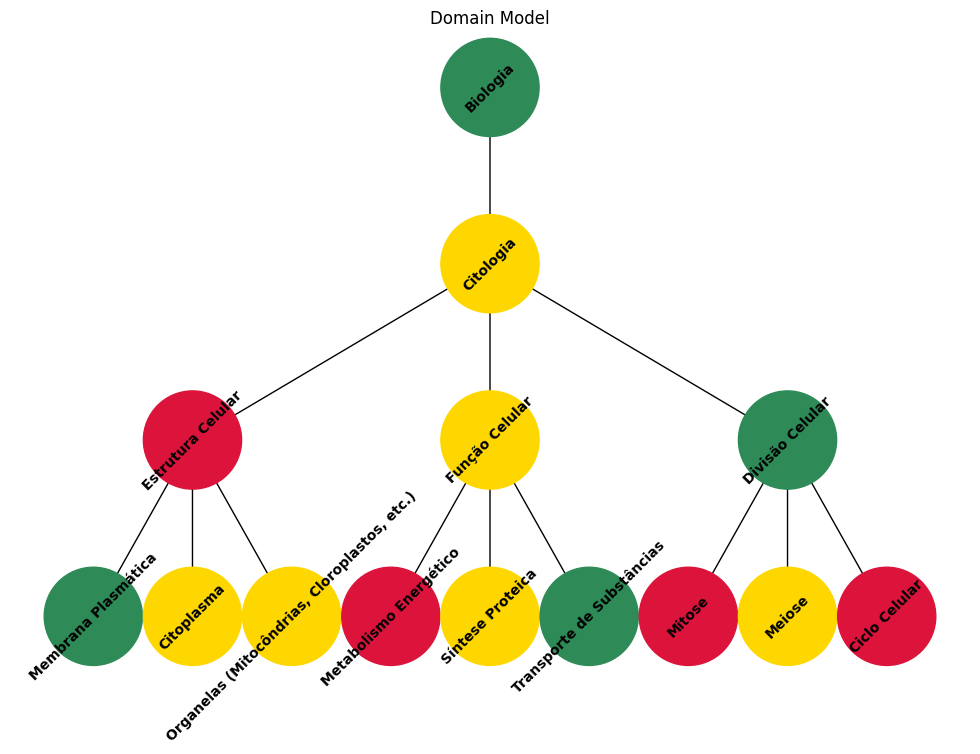

In [9]:
domain_model.plot(area='Biologia', topico='Citologia', simulate_colors=True)

#### Load ENEM as the DomainModel

In [10]:
enem = ENEM(
    domain_file="https://raw.githubusercontent.com/adaj/its-enem/refs/heads/main/model/domain.yml",
    enem_file="https://raw.githubusercontent.com/adaj/its-enem/refs/heads/main/data/enem_2024_09042025.jsonl"
)

# # Access the loaded questions
pd.DataFrame(enem.questions).head()

,id,correct,difficulty,topics
0,questao_91,D,medium,"{'Biologia': [['Ecologia'], ['Seleção Natural'..."
1,questao_92,D,easy,{'Biologia': [['Fisiologia Humana']]}
2,questao_93,B,medium,"{'Biologia': [['Genética'], ['Leis de Mendel']]}"
3,questao_94,D,medium,"{'Biologia': [['Ecologia'], ['Impacto Ambienta..."
4,questao_95,D,easy,"{'Física': [['Óptica'], ['Refração']]}"


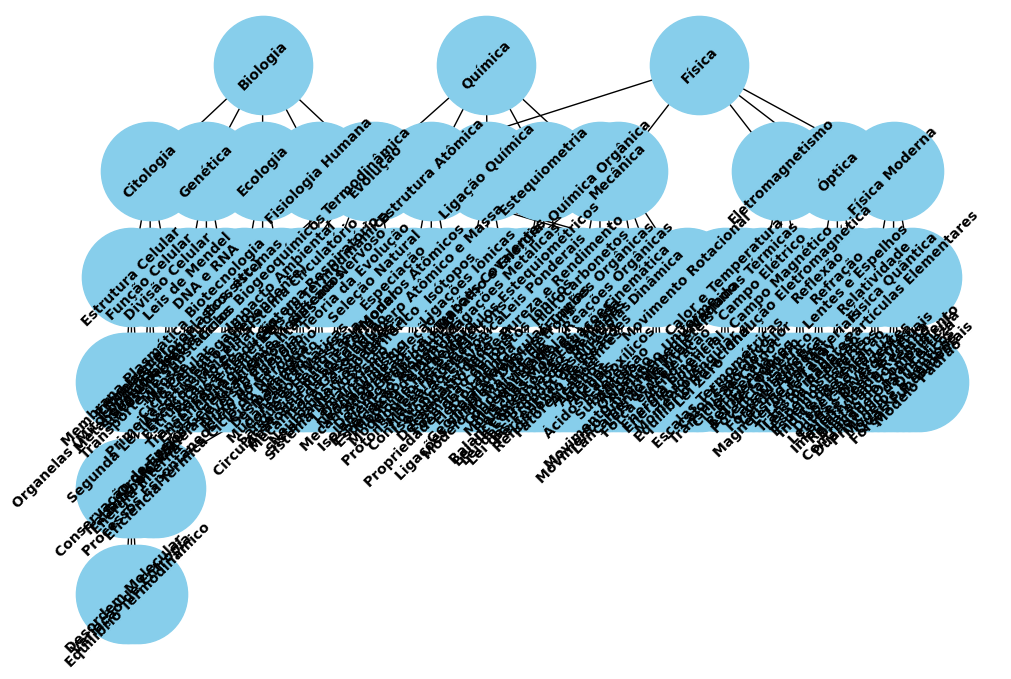

In [11]:
enem.plot()

### Load Pedagogy

In [12]:
# pedagogy_model.rules

In [13]:
pedagogy_file = "https://raw.githubusercontent.com/adaj/its-enem/refs/heads/main/model/pedagogy.yml"

pedagogy_model = PedagogyModel(pedagogy_file)
pedagogy_model.print_rules()

Pedagogical Rules:
  Rule: Relatedness for low easy question performance in topic
    Condition: performance.topics[topic].total_questions >= 2 AND performance.topics[topic].percent_correct_easy_questions < 60.0
    Action: {'feedback_relatedness[topic]': 1}

  Rule: Competence for high hard question performance in topic
    Condition: performance.topics[topic].total_questions >= 2 AND performance.topics[topic].percent_correct_high_questions > 70.0
    Action: {'feedback_competence[topic]': 1}

  Rule: Autonomy for moderate medium question performance in topic
    Condition: performance.topics[topic].total_questions >= 2 AND performance.topics[topic].percent_correct_medium_questions >= 50.0 AND performance.topics[topic].percent_correct_medium_questions <= 80.0
    Action: {'feedback_autonomy[topic]': 1}

  Rule: Urgent focus due to very low easy question performance in topic
    Condition: performance.topics[topic].total_questions >= 2 AND performance.topics[topic].percent_correct_easy

### Creating a simulated Learner's input (ENEM's gabarito, questions 91-135)

In [14]:
import random

random_answers = {f"questao_{i}": random.choice("ABCDE") for i in range(46, 136)}

learner = LearnerModel(id="learner_001", answers=random_answers)
learner

LearnerModel(id='learner_001', answers={'questao_46': 'C', 'questao_47': 'E', 'questao_48': 'E', 'questao_49': 'C', 'questao_50': 'E', 'questao_51': 'E', 'questao_52': 'A', 'questao_53': 'D', 'questao_54': 'D', 'questao_55': 'E', 'questao_56': 'A', 'questao_57': 'D', 'questao_58': 'D', 'questao_59': 'E', 'questao_60': 'B', 'questao_61': 'B', 'questao_62': 'C', 'questao_63': 'D', 'questao_64': 'D', 'questao_65': 'B', 'questao_66': 'B', 'questao_67': 'C', 'questao_68': 'B', 'questao_69': 'D', 'questao_70': 'E', 'questao_71': 'E', 'questao_72': 'E', 'questao_73': 'B', 'questao_74': 'B', 'questao_75': 'B', 'questao_76': 'D', 'questao_77': 'D', 'questao_78': 'C', 'questao_79': 'B', 'questao_80': 'C', 'questao_81': 'A', 'questao_82': 'A', 'questao_83': 'D', 'questao_84': 'B', 'questao_85': 'D', 'questao_86': 'D', 'questao_87': 'B', 'questao_88': 'A', 'questao_89': 'C', 'questao_90': 'A', 'questao_91': 'B', 'questao_92': 'D', 'questao_93': 'E', 'questao_94': 'A', 'questao_95': 'D', 'questao_9

### Initializing the ITS Controller with ENEM's questions

In [15]:
controller = Controller(enem, pedagogy_model, questions=enem.questions)
controller

### Evaluate learner performance

In [16]:
# Example usage with a single learner
learner = LearnerModel(id="learner_001", answers=random_answers)

# First step is to process the learner information to extract the learner model
learner = controller.process_learner(learner)

print("\nLearner Model:\n")
learner.print_performance()


Learner Model:

Performance for learner_001:
  Topics:
    Ecologia: {'total_questions': 7, 'points': 0, 'percent_correct_easy_questions': 0.0, 'percent_correct_medium_questions': 0.0, 'percent_correct_high_questions': 0.0}
    Seleção Natural: {'total_questions': 1, 'points': 0, 'percent_correct_easy_questions': 0.0, 'percent_correct_medium_questions': 0.0, 'percent_correct_high_questions': 0.0}
    Adaptação: {'total_questions': 1, 'points': 0, 'percent_correct_easy_questions': 0.0, 'percent_correct_medium_questions': 0.0, 'percent_correct_high_questions': 0.0}
    Fisiologia Humana: {'total_questions': 6, 'points': 3, 'percent_correct_easy_questions': 50.0, 'percent_correct_medium_questions': 25.0, 'percent_correct_high_questions': 0.0}
    Genética: {'total_questions': 2, 'points': 0, 'percent_correct_easy_questions': 0.0, 'percent_correct_medium_questions': 0.0, 'percent_correct_high_questions': 0.0}
    Leis de Mendel: {'total_questions': 1, 'points': 0, 'percent_correct_easy_qu

### Apply pedagogical rules to check feedback flags

In [17]:
feedback_flags = controller.apply_pedagogy(learner)
feedback_flags

{'topics': {'Ecologia': {'needs_review': True},
  'Seleção Natural': {'needs_review': True},
  'Adaptação': {'needs_review': True},
  'Fisiologia Humana': {'needs_review': True},
  'Genética': {'needs_review': True},
  'Leis de Mendel': {'needs_review': True},
  'Impacto Ambiental': {'needs_review': True},
  'Óptica': {'needs_review': True},
  'Refração': {'needs_review': True},
  'Ecossistemas': {'needs_review': True},
  'Sucessão Ecológica': {'needs_review': True},
  'Citologia': {'needs_review': True},
  'Função Celular': {'needs_review': True},
  'Termodinâmica': {'needs_review': True},
  'Calor e Temperatura': {'needs_review': True},
  'Transmissão de Calor': {'needs_review': True},
  'Ciclos Biogeoquímicos': {'needs_review': True},
  'Química Orgânica': {'needs_review': True},
  'Hidrocarbonetos': {'needs_review': True},
  'Mecânica': {'needs_review': True},
  'Trabalho e Energia': {'needs_review': True},
  'Energia Cinética': {'needs_review': True},
  'Eletromagnetismo': {'needs

### Final tutoring report

In [18]:
print (controller.generate_report(feedback_flags, learner.id))

Feedback Report for learner_001

**Feedback on Topics:**
- 🟡 Considere revisar Adaptação 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Biotecnologia 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Calor Específico 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Calor e Temperatura 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Campo Elétrico 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Ciclo de Carnot 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Ciclos Biogeoquímicos 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Cinemática 🔄, especialmente os conceitos mais difíceis, para melhorar seu domínio. 📚
- 🟡 Considere revisar Citologia 🔄, especialmente o